In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [18]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import pandas
import pandas as pd
import json
import tensorflow as tf
import tf_data
import loader
from plotting import *

In [2]:
import tensorflow as tf
import json, os
import numpy as np

# Tested with TensorFlow 2.1.0
print('version={}, CUDA={}, GPU={}, TPU={}'.format(
    tf.__version__, tf.test.is_built_with_cuda(),
    # GPU attached?
    len(tf.config.list_physical_devices('GPU')) > 0,
    # TPU accessible? (only works on Colab)
    'COLAB_TPU_ADDR' in os.environ))

if len(tf.config.list_physical_devices('GPU')) > 0:
    physical_devices = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
    strategy = tf.distribute.OneDeviceStrategy("gpu:0")

version=2.3.0, CUDA=False, GPU=False, TPU=False


In [3]:
model_dir = "/eos/user/d/dvalsecc/www/ECAL/Clustering/DeepCluster/models_archive/gcn_models/gcn_models_SA_v11/run_01"

In [4]:
args = json.load(open(model_dir + "/args_load.json"))

In [5]:
args

{'models_path': '/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v11/',
 'load': False,
 'initial_epoch': 0,
 'nepochs': 100,
 'ntrain': 800000,
 'nval': 200000,
 'lr_decay': 0.0,
 'lr': 0.001,
 'batch_size': 512,
 'opt': 'adam',
 'activation': 'elu',
 'output_dim_rechits': 18,
 'output_dim_nodes': 64,
 'output_dim_gconv': 64,
 'output_dim_sa_clclass': 64,
 'output_dim_sa_windclass': 64,
 'output_dim_sa_enregr': 64,
 'coord_dim': 3,
 'coord_dim_sa': 15,
 'nconv_rechits': 3,
 'nconv': 3,
 'layers_input': [128, 128, 64],
 'layers_clclass': [256, 128, 64],
 'layers_windclass': [128, 64, 64],
 'layers_enregr': [128, 64, 32],
 'n_windclasses': 3,
 'dropout': 0.1,
 'l2_reg': True,
 'loss_clusters': 2,
 'loss_window': 1,
 'loss_softF1': 0.5,
 'loss_et_miss': 5,
 'loss_et_spur': 5,
 'loss_en_regr': 0.0,
 'features_dict': {'cl_features': ['en_cluster',
   'et_cluster',
   'cluster_eta',
   'cluster_phi',
   'cluster_ieta',
   'cluster_iphi',
   'cluster_iz',

In [6]:
nevents_train = 1000000
nevents_test = 300000
dataset_version = "v10"
output_path = args["models_path"] + '/run_01/en_regr/'

### Dataset loading

In [7]:
def get_unique_run():
    previous_runs = os.listdir(output_path)
    if len(previous_runs) == 0:
        run_number = 1
    else:
        run_number = max([int(s.split('run_')[1]) for s in previous_runs]) + 1
    return run_number


if not os.path.isdir(output_path):
    os.makedirs(output_path)

name =  'run_{:02}'.format(get_unique_run())

outdir = output_path + name

if os.path.isdir(outdir):
    print("Output directory exists: {}".format(outdir), file=sys.stderr)
else:
    os.makedirs(outdir)

print(outdir)

/eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v11//run_01/en_regr/run_02


In [8]:
features_dict = args['features_dict']

In [9]:
data_path_train = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/training/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v10/training/calo_matched/*.proto",
                 # "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/training/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/training/no_calo_matched/*.proto"
                  }
data_path_test = {"ele_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/testing/calo_matched/*.proto",
                  "gamma_match": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v10/testing/calo_matched/*.proto",
                  # "nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/testing/no_calo_matched/*.proto",
                  #"gamma_nomatch": "/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v2/testing/no_calo_matched/*.proto"
                  }

In [10]:
# Load a balanced dataset from the list of paths given to the function. Selected only the requestes features from clusters and prepare batches
train_ds = tf_data.load_balanced_dataset_batch( data_path_train, features_dict, args['batch_size'],weights={"ele_match":0.5,"gamma_match":0.5} )#weights={"ele_match":0.4,"gamma_match":0.4}
# the indexes for energy and et are from the features list we requestes
# train_ds = tf_data.delta_energy_seed(train_ds, en_index=0, et_index=1)
train_ds = tf_data.normalize_features(train_ds, "normalization_v10.npz", "normalization_wind_features_v10.npz")
train_ds = tf_data.training_format(train_ds)


test_ds = tf_data.load_balanced_dataset_batch(data_path_test,features_dict,args['batch_size'],weights={"ele_match":0.5,"gamma_match":0.5})
# the indexes for energy and et are from the features list we requestes
# test_ds = tf_data.delta_energy_seed(test_ds, en_index=0, et_index=1)
test_ds = tf_data.normalize_features(test_ds, "normalization_v10.npz", "normalization_wind_features_v10.npz")
test_ds = tf_data.training_format(test_ds)

# Create training and validation
ds_train = train_ds.prefetch(300).take(nevents_train // args['batch_size']).repeat(200)
ds_test  = test_ds.prefetch(300).take(nevents_test // args['batch_size']).repeat(200)

In [11]:
X ,y = tf_data.get(ds_train)

In [14]:
#with strategy.scope():
model = loader.get_model(args["models_path"] + '/run_01/args_load.json', 
                        args["models_path"] + '/run_01//model.py',
             weights_path=args["models_path"]+ "/run_01/" + 'weights.best.hdf5', X=X)

loss_weights = {"clusters":0., "window":0., "softF1":0., "et_miss":0., "et_spur":0., "en_regr":100.}
model.loss_weights = loss_weights

for layer in model.layers:
    if layer.name not in ["SA_enregr","dense_enregr"]:
        layer.trainable = False

[ (l.name, l.trainable) for l in model.layers]

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt)

Model options: 
{'activation': 'elu',
 'batch_size': 512,
 'coord_dim': 3,
 'coord_dim_sa': 15,
 'data_path': {'ele_match': '/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/electrons/recordio_allinfo_v10/training/calo_matched/*.proto',
               'gamma_match': '/eos/user/r/rdfexp/ecal/cluster/output_deepcluster_dumper/windows_data/gammas/recordio_allinfo_v10/training/calo_matched/*.proto'},
 'dropout': 0.1,
 'features_dict': {'cl_features': ['en_cluster',
                                   'et_cluster',
                                   'cluster_eta',
                                   'cluster_phi',
                                   'cluster_ieta',
                                   'cluster_iphi',
                                   'cluster_iz',
                                   'cluster_deta',
                                   'cluster_dphi',
                                   'cluster_den_seed',
                                   'cluster_det_seed',


In [15]:
X,y = tf_data.get(ds_test)

In [16]:
(dense_clclass, windclass, enregr), mask_cls, \
    (cl_X, coord, adj, coord_att_ws, output_rechits, out_gcn, out_SAcl ,out_SAw, att_weights_clcall, att_w_windclass,att_weights_en) = model(X)

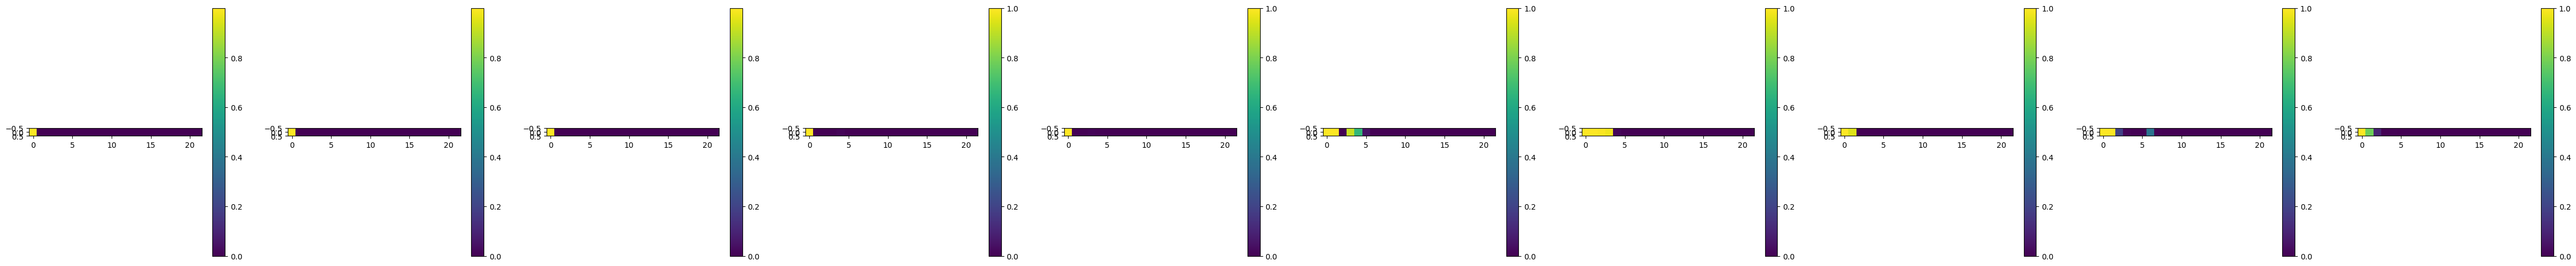

In [28]:
plotM(*(tf.nn.sigmoid(dense_clclass)* mask_cls[:,:,tf.newaxis])[0:10])

In [23]:
mask_cls

<tf.Tensor: shape=(512, 22), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)>

<tf.Tensor: shape=(512, 22, 1), dtype=float32, numpy=
array([[[9.9999988e-01],
        [0.0000000e+00],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[9.9999976e-01],
        [2.0635128e-04],
        [0.0000000e+00],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[9.9999976e-01],
        [6.4444146e-05],
        [2.4089217e-04],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       ...,

       [[1.0000000e+00],
        [1.2540817e-04],
        [3.1523973e-02],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[1.0000000e+00],
        [7.5412393e-03],
        [3.6585294e-05],
        ...,
        [0.0000000e+00],
        [0.0000000e+00],
        [0.0000000e+00]],

       [[1.0000000e+00],
        [9.4027069e-05],
        [2.0303716e-05],
        ...,
        [0.0000000e+

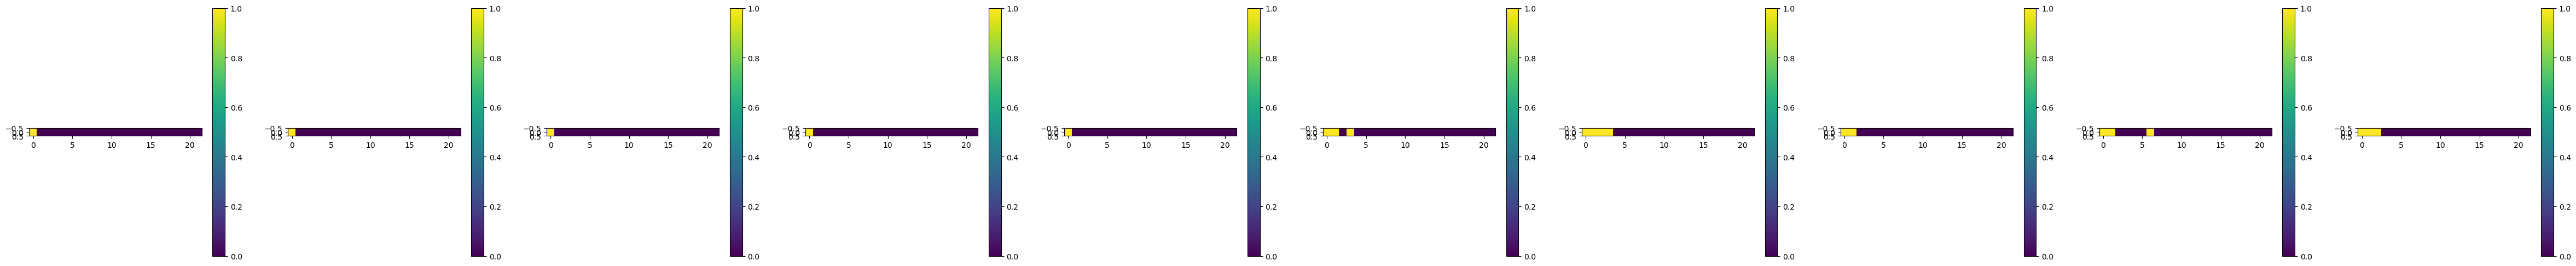

In [20]:
plotM(*y[0][0:10])


In [33]:
callbacks = []
tb = tf.keras.callbacks.TensorBoard(
    log_dir=outdir, histogram_freq=2, 
    write_graph=False, 
    write_images=True,
    update_freq='epoch',
    profile_batch=0,
)
tb.set_model(model)
callbacks += [tb]

terminate_cb = tf.keras.callbacks.TerminateOnNaN()
callbacks += [terminate_cb]

lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1,
    mode='auto', min_delta=0.001, cooldown=0, min_lr=1e-8,
)


cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=outdir + "/weights.{epoch:02d}-{val_loss:.6f}.hdf5",
    save_weights_only=True,
    verbose=1
)
cp_callback.set_model(model)


early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0.001, patience=15, verbose=1,
    mode='auto', baseline=None, restore_best_weights=False
)
early.set_model(model)



callbacks += [cp_callback, lr_reduce, early]


In [34]:
[ (l.name, l.trainable) for l in model.layers]

[('graph_builder', False),
 ('GHN_global', False),
 ('SA_clclass', False),
 ('dense_clclass', False),
 ('SA_windclass', False),
 ('dense_windclass', False),
 ('SA_enregr', True),
 ('dense_enregr', True),
 ('dropout_24', False),
 ('dropout_25', False),
 ('gcn_output_layernorm', False),
 ('SA_windclass_layernorm', False),
 ('concatenate_1', False),
 ('concatenate_2', False),
 ('concatenate_3', False),
 ('loss', False),
 ('loss_clusters', False),
 ('loss_windows', False),
 ('loss_softF1', False),
 ('loss_et_miss', False),
 ('loss_et_spur', False),
 ('loss_en_regr', False)]

In [35]:
ret = model.fit(ds_train,
        validation_data=ds_test, 
        epochs=200,
        steps_per_epoch=nevents_train//args['batch_size'], 
        validation_steps=nevents_test//args['batch_size'],
        verbose=True,
        callbacks = callbacks,
        initial_epoch = 0
    )

Epoch 1/200
1953/1953 [==============================] - ETA: 0s - loss: 3.2863 - loss_clusters: 0.5183 - loss_windows: 0.6332 - loss_softF1: 0.7112 - loss_et_miss: 0.0658 - loss_et_spur: 0.0680 - loss_en_regr: 0.0323
Epoch 00001: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v11//run_01/en_regr/run_04/weights.01-5.072040.hdf5
1953/1953 [==============================] - 231s 118ms/step - loss: 3.2863 - loss_clusters: 0.5183 - loss_windows: 0.6332 - loss_softF1: 0.7112 - loss_et_miss: 0.0658 - loss_et_spur: 0.0680 - loss_en_regr: 0.0323 - val_loss: 5.0720 - val_loss_clusters: 0.5008 - val_loss_windows: 0.6305 - val_loss_softF1: 0.7088 - val_loss_et_miss: 0.0574 - val_loss_et_spur: 0.0691 - val_loss_en_regr: 0.0501
Epoch 2/200
1953/1953 [==============================] - ETA: 0s - loss: 3.1320 - loss_clusters: 0.5179 - loss_windows: 0.6331 - loss_softF1: 0.7109 - loss_et_miss: 0.0658 - loss_et_spur: 0.0679 - loss_en_regr: 0.0307
Epo

Epoch 12/200
1953/1953 [==============================] - ETA: 0s - loss: 3.0179 - loss_clusters: 0.5179 - loss_windows: 0.6332 - loss_softF1: 0.7119 - loss_et_miss: 0.0657 - loss_et_spur: 0.0681 - loss_en_regr: 0.0295
Epoch 00012: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v11//run_01/en_regr/run_04/weights.12-5.172826.hdf5
1953/1953 [==============================] - 227s 116ms/step - loss: 3.0179 - loss_clusters: 0.5179 - loss_windows: 0.6332 - loss_softF1: 0.7119 - loss_et_miss: 0.0657 - loss_et_spur: 0.0681 - loss_en_regr: 0.0295 - val_loss: 5.1728 - val_loss_clusters: 0.5020 - val_loss_windows: 0.6305 - val_loss_softF1: 0.7082 - val_loss_et_miss: 0.0575 - val_loss_et_spur: 0.0693 - val_loss_en_regr: 0.0510
Epoch 13/200
1953/1953 [==============================] - ETA: 0s - loss: 3.0036 - loss_clusters: 0.5185 - loss_windows: 0.6332 - loss_softF1: 0.7121 - loss_et_miss: 0.0658 - loss_et_spur: 0.0682 - loss_en_regr: 0.0293
E

Epoch 23/200
1953/1953 [==============================] - ETA: 0s - loss: 2.9566 - loss_clusters: 0.5182 - loss_windows: 0.6332 - loss_softF1: 0.7112 - loss_et_miss: 0.0658 - loss_et_spur: 0.0679 - loss_en_regr: 0.0289
Epoch 00023: saving model to /eos/user/d/dvalsecc/ECAL/EcalClustering/DeepCluster/models/gcn_models/gcn_models_SA_v11//run_01/en_regr/run_04/weights.23-4.643779.hdf5
1953/1953 [==============================] - 226s 116ms/step - loss: 2.9566 - loss_clusters: 0.5182 - loss_windows: 0.6332 - loss_softF1: 0.7112 - loss_et_miss: 0.0658 - loss_et_spur: 0.0679 - loss_en_regr: 0.0289 - val_loss: 4.6438 - val_loss_clusters: 0.4994 - val_loss_windows: 0.6301 - val_loss_softF1: 0.7100 - val_loss_et_miss: 0.0572 - val_loss_et_spur: 0.0690 - val_loss_en_regr: 0.0458
Epoch 24/200
1953/1953 [==============================] - ETA: 0s - loss: 2.9684 - loss_clusters: 0.5181 - loss_windows: 0.6332 - loss_softF1: 0.7111 - loss_et_miss: 0.0659 - loss_et_spur: 0.0681 - loss_en_regr: 0.0290
E

In [39]:
import mplhep as hep
plt.style.use(hep.style.CMS)

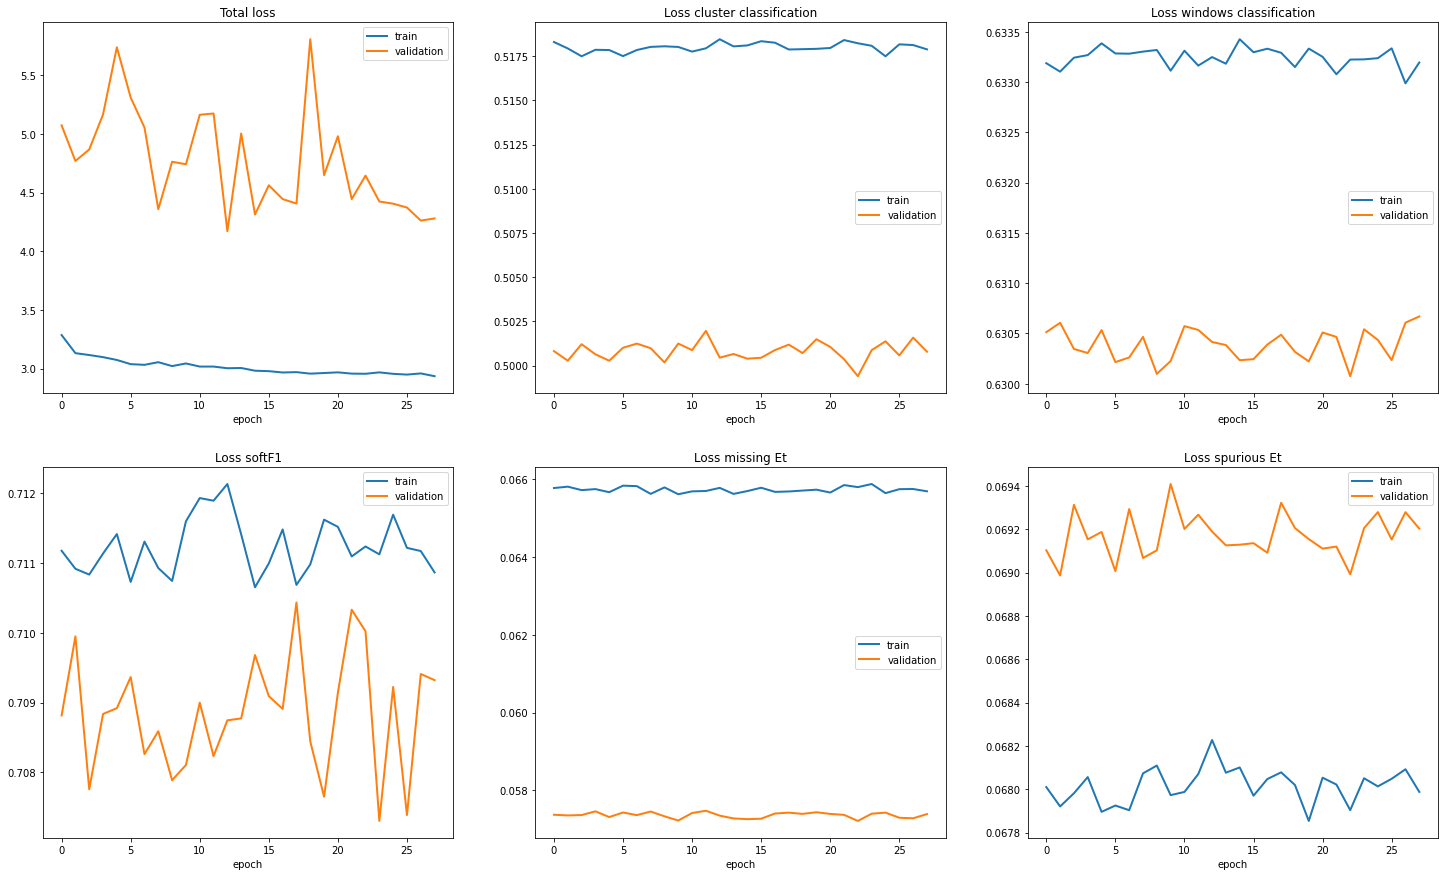

In [36]:
f, ((ax1, ax2, ax3),(ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(25, 15))

ax1.plot(ret.history["loss"], label="train", linewidth=2)
ax1.plot(ret.history["val_loss"],label="validation", linewidth=2)
ax1.set_title("Total loss")
ax1.set_xlabel("epoch")
ax1.legend()

ax2.plot(ret.history["loss_clusters"], label="train", linewidth=2)
ax2.plot(ret.history["val_loss_clusters"],label="validation", linewidth=2)
ax2.set_title("Loss cluster classification")
ax2.set_xlabel("epoch")
ax2.legend()

ax3.plot(ret.history["loss_windows"], label="train", linewidth=2)
ax3.plot(ret.history["val_loss_windows"],label="validation", linewidth=2)
ax3.set_title("Loss windows classification")
ax3.set_xlabel("epoch")
ax3.legend()

ax4.plot(ret.history["loss_softF1"], label="train", linewidth=2)
ax4.plot(ret.history["val_loss_softF1"],label="validation", linewidth=2)
ax4.set_title("Loss softF1")
ax4.set_xlabel("epoch")
ax4.legend()

ax5.plot(ret.history["loss_et_miss"], label="train", linewidth=2)
ax5.plot(ret.history["val_loss_et_miss"],label="validation", linewidth=2)
ax5.set_title("Loss missing Et")
ax5.set_xlabel("epoch")
ax5.legend()

ax6.plot(ret.history["loss_et_spur"], label="train", linewidth=2)
ax6.plot(ret.history["val_loss_et_spur"],label="validation", linewidth=2)
ax6.set_title("Loss spurious Et")
ax6.set_xlabel("epoch")
ax6.legend()

f.savefig(outdir + "/train_loss.png")


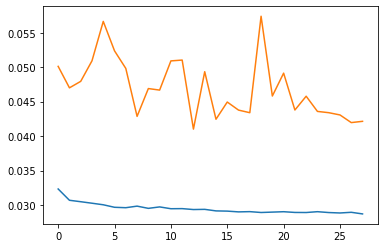

In [38]:
plt.plot(ret.history["loss_en_regr"])
plt.plot(ret.history["val_loss_en_regr"])

In [42]:
with open(outdir + "/args.txt",'w') as config:
    config.write(str(args))

conf = [ 'models_path', 'load','initial_epoch','nepochs','ntrain','nval',
                           'lr_decay','lr', 'batch_size','opt', 'activation', 
                           'output_dim_rechits', 'output_dim_nodes', 'output_dim_gconv', 'output_dim_sa_clclass',
                           'output_dim_sa_windclass','output_dim_sa_enregr','coord_dim','coord_dim_sa','nconv_rechits','nconv', 
                           'layers_input','layers_clclass','layers_windclass','layers_enregr', 'n_windclasses',
                          'dropout','l2_reg','loss_clusters','loss_window','loss_softF1','loss_et_miss','loss_et_spur','loss_en_regr']

configs = {}
for c in conf:
    if c == 'activation': configs[c] = "elu"
    else: configs[c] = getattr(args, c)
        
configs["features_dict"] = features_dict
configs["data_path"] = data_path_train
    
import json
json.dump(configs, open(outdir + "/args_load.json","w"), indent=2)

In [ ]:
configs

### Test loss

In [76]:
X,y_true= tf_data.get(ds_test)

In [77]:
y_pred = model(X)

In [78]:
(dense_clclass, dense_windclass, en_regr_factor), mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, wind_X, y_metadata, cl_labels = y_true
cl_ens = cl_X[:,:,0]
pred_en =  tf.reduce_sum(cl_ens * tf.squeeze(tf.cast(tf.nn.sigmoid(dense_clclass) > 0.5 , tf.float32)), axis=-1)
corrected_en =  pred_en * tf.squeeze(en_regr_factor)
true_en_gen = y_metadata[:,2]
a = tf.reduce_mean(tf.square(corrected_en - true_en_gen))

(array([[1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.97505146, 1.1114011 , 1.2477508 , 1.3841004 , 1.5204501 ,
        1.6567998 , 1.7931495 , 1.9294991 , 2.0658488 , 2.2021985 ,
        2.3385482 ], dtype=float32),
 <a list of 512 BarContainer objects>)

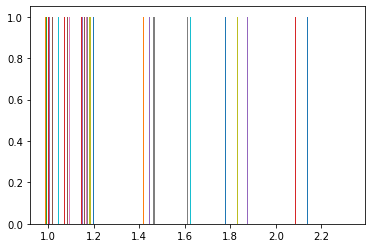

In [83]:
plt.hist(en_regr_factor* 3)

In [117]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)
diff = tf.math.abs(y_target - pred_prob)
Et = cl_X[:,:,1:2]

missing_en = Et * diff * y_target
spurious_en =  Et * diff * (1 - y_target)

reduced_loss_missing = tf.reduce_mean(tf.reduce_sum(missing_en, axis=1)) 
reduced_loss_spurious =  tf.reduce_mean(tf.reduce_sum(spurious_en, axis=1))

In [160]:
dense_clclass,dense_windclass, mask_cls, _  = y_pred
y_clclass, y_windclass, cl_X, y_metadata = y_true
y_target = tf.cast(y_clclass, tf.float32) 

pred_prob = tf.nn.sigmoid(dense_clclass)

In [169]:
tp = pred_prob * y_target
fn = (1 - pred_prob) * y_target
fp = pred_prob * (1 - y_target)

In [182]:
tptot = tf.reduce_sum(tp, axis=1)
fntot = tf.reduce_sum(fn, axis=1)
fptot = tf.reduce_sum(fp, axis=1)

In [187]:
1 - (2 * tptot)/ (2*tptot + fntot + fptot + 1e-16) 

<tf.Tensor: shape=(128, 1), dtype=float32, numpy=
array([[0.8643937 ],
       [0.8417007 ],
       [0.7678521 ],
       [0.8621445 ],
       [0.8818361 ],
       [0.6749588 ],
       [0.86786455],
       [0.84230775],
       [0.8560391 ],
       [0.84797996],
       [0.8713441 ],
       [0.8565036 ],
       [0.87739176],
       [0.86709696],
       [0.855233  ],
       [0.86079264],
       [0.8512083 ],
       [0.86182773],
       [0.68536377],
       [0.8597818 ],
       [0.86351144],
       [0.863147  ],
       [0.85580873],
       [0.85421795],
       [0.87876534],
       [0.8604276 ],
       [0.86217374],
       [0.8579935 ],
       [0.86134374],
       [0.8482436 ],
       [0.8498958 ],
       [0.8549104 ],
       [0.8570379 ],
       [0.8734256 ],
       [0.8786647 ],
       [0.8799868 ],
       [0.8757078 ],
       [0.8537595 ],
       [0.8767978 ],
       [0.86964816],
       [0.8642583 ],
       [0.85530466],
       [0.86631775],
       [0.5863811 ],
       [0.85295665],
     

In [130]:
reduced_loss_spurious

<tf.Tensor: shape=(), dtype=float32, numpy=0.064462475>

### Layers inspection

In [192]:
model.layers

In [193]:
graphbuild = model.layers[0]

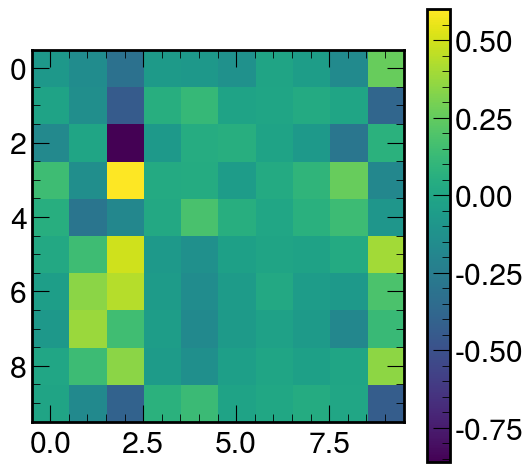

In [194]:
plotM(graphbuild.rechitsGCN.weights[2].numpy())